In [ ]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/

 ch10p1.mp4	    data.zip   'sanction-letter-A2205200568 (1).pdf'
 ch6p1.mp4	    hw3_data    sanction-letter-A2205200568.pdf
 ch6p2.mp4	    images      trip
 ch9.mp4	    Lor        'view?usp=share_link'
'Colab Notebooks'   monte.mp4


In [ ]:
import os
os.chdir("drive/MyDrive/")

In [ ]:
# !unzip data.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
!ls

 ch10p1.mp4	    data.zip   'sanction-letter-A2205200568 (1).pdf'
 ch6p1.mp4	    hw3_data    sanction-letter-A2205200568.pdf
 ch6p2.mp4	    images      trip
 ch9.mp4	    Lor        'view?usp=share_link'
'Colab Notebooks'   monte.mp4


In [ ]:
data_dir = "images/"

In [ ]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['images', 'train', 'validation']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms

In [ ]:
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])
dataset = ImageFolder(data_dir+'/train', transform=data_transform)

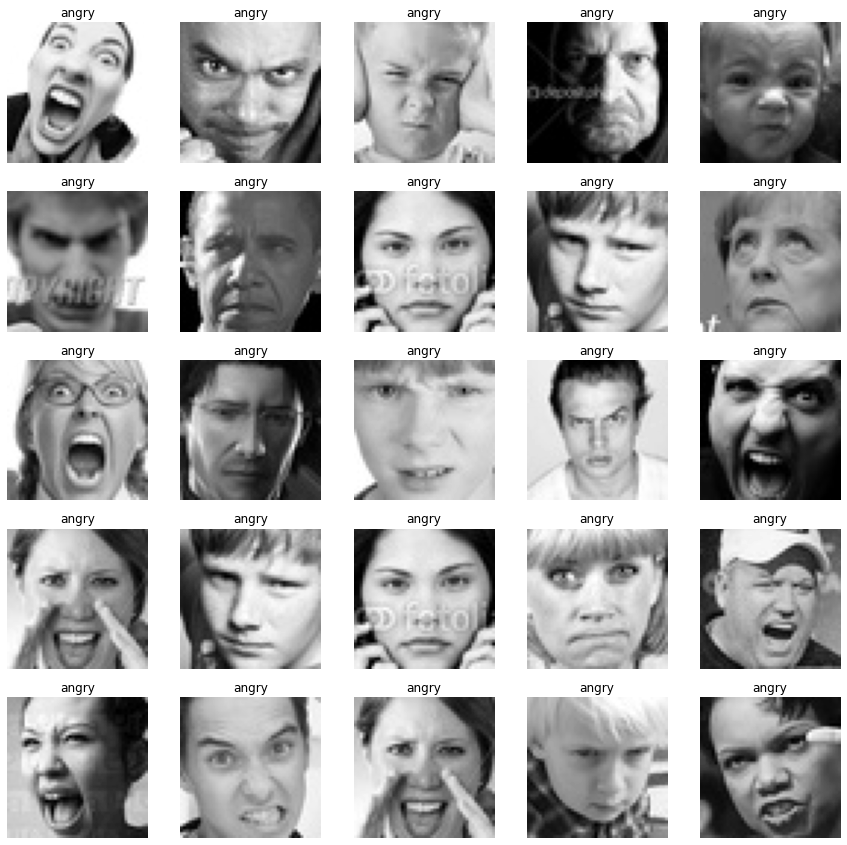

In [ ]:
n_rows=5
n_cols=5
plt.figure(figsize=(15,15))
for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(dataset))
        img,label=dataset[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img.permute(1,2,0),cmap="gray")
        plt.axis('off')
        plt.title(dataset.classes[label])
plt.show()

In [ ]:
img, label = dataset[500]
print(img.shape, label)
img

torch.Size([1, 48, 48]) 0


tensor([[[0.3961, 0.3922, 0.3137,  ..., 0.2157, 0.2118, 0.1725],
         [0.3765, 0.3922, 0.2784,  ..., 0.2157, 0.1882, 0.1804],
         [0.3569, 0.3804, 0.2745,  ..., 0.2039, 0.1765, 0.1647],
         ...,
         [0.3765, 0.5725, 0.3569,  ..., 0.6863, 0.8235, 0.9373],
         [0.5961, 0.6000, 0.3451,  ..., 0.7490, 0.6078, 0.7569],
         [0.5725, 0.6078, 0.4118,  ..., 0.7922, 0.6784, 0.6549]]])

In [ ]:
dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(5192, 5000)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*6*6, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, data):
        images, labels = data 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)
        # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    

In [5]:
model1 = net().to(device)

In [6]:
model1

net(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, o

In [ ]:
from tqdm import tqdm

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).numpy()

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return outputs

In [ ]:
def fit(model,epochs,criterion,optimizer):
    n_total_steps = len(train_dl)
    history={"acc":[],"loss":[],"val_loss":[],"val_acc":[]}
    for epoch in range(epochs):
        l=[]
        a=[]
        vl=[]
        va=[]
        for i, (images, labels) in tqdm(enumerate(train_dl),total=len(train_dl)):
            local_loss=[]
            local_acc=[]
            val_ls=[]
            val_acc=[]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs,labels)
            ev = evaluate(model,val_dl)[0]
            val_ls.append(ev["val_loss"])
            val_acc.append(ev["val_acc"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            local_loss.append(loss.item())
            local_acc.append(acc)
            if (i+1)%len(train_dl) == 0:
                l.append(sum(local_loss)/len(local_loss))
                a.append(sum(local_acc)/len(local_acc))
                va.append(sum(val_acc)/len(val_acc))
                vl.append(sum(val_ls)/len(val_ls))

        print (f'Epoch [{epoch+1}/{10}], Loss: {sum(local_loss)/len(local_loss):.4f},Accuracy: {sum(local_acc)/len(local_acc):.4f}')
        history["acc"].append(a[-1])
        history["loss"].append(l[-1])
        history["val_loss"].append(vl[-1])
        history["val_acc"].append(va[-1])
    return history


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
history = fit(model1,10,criterion,optimizer)

100%|██████████| 41/41 [04:14<00:00,  6.21s/it]

Epoch [1/10], Loss: 1.0777,Accuracy: 0.5139



100%|██████████| 41/41 [04:09<00:00,  6.09s/it]

Epoch [2/10], Loss: 1.1806,Accuracy: 0.4583



100%|██████████| 41/41 [04:07<00:00,  6.03s/it]

Epoch [3/10], Loss: 1.1599,Accuracy: 0.3333



100%|██████████| 41/41 [04:07<00:00,  6.03s/it]

Epoch [4/10], Loss: 1.0597,Accuracy: 0.4444



100%|██████████| 41/41 [04:06<00:00,  6.01s/it]

Epoch [5/10], Loss: 1.2635,Accuracy: 0.3611



100%|██████████| 41/41 [04:07<00:00,  6.04s/it]

Epoch [6/10], Loss: 1.1171,Accuracy: 0.5139



100%|██████████| 41/41 [04:08<00:00,  6.06s/it]

Epoch [7/10], Loss: 1.1640,Accuracy: 0.4722



100%|██████████| 41/41 [04:07<00:00,  6.03s/it]

Epoch [8/10], Loss: 1.0182,Accuracy: 0.5694



100%|██████████| 41/41 [04:06<00:00,  6.02s/it]

Epoch [9/10], Loss: 1.0802,Accuracy: 0.6111



100%|██████████| 41/41 [04:08<00:00,  6.07s/it]

Epoch [10/10], Loss: 1.1747,Accuracy: 0.4861


In [ ]:
history

{'acc': [0.5138888955116272,
  0.4583333432674408,
  0.3333333432674408,
  0.4444444477558136,
  0.3611111044883728,
  0.5138888955116272,
  0.4722222089767456,
  0.5694444179534912,
  0.6111111044883728,
  0.4861111044883728],
 'loss': [1.0777267217636108,
  1.1806340217590332,
  1.1599417924880981,
  1.0596842765808105,
  1.2635358572006226,
  1.117073893547058,
  1.1640219688415527,
  1.0182037353515625,
  1.0802216529846191,
  1.1746981143951416],
 'val_loss': [tensor(1.2040, device='cuda:0'),
  tensor(1.2000, device='cuda:0'),
  tensor(1.1911, device='cuda:0'),
  tensor(1.2076, device='cuda:0'),
  tensor(1.2057, device='cuda:0'),
  tensor(1.1963, device='cuda:0'),
  tensor(1.1996, device='cuda:0'),
  tensor(1.2098, device='cuda:0'),
  tensor(1.1720, device='cuda:0'),
  tensor(1.1268, device='cuda:0')],
 'val_acc': [0.34765625,
  0.41015625,
  0.41015625,
  0.34765625,
  0.34765625,
  0.41015625,
  0.3984375,
  0.39453125,
  0.40234375,
  0.48828125]}

In [ ]:
accuracy = history["acc"]
loss= history["loss"]
val_loss=[]
for i in history["val_loss"]:
  val_loss.append(i.cpu().numpy())
val_acc = history["val_acc"]

Text(0, 0.5, 'loss')

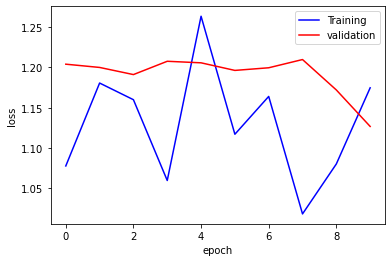

In [ ]:
plt.plot(loss,'-b')
plt.plot(val_loss,'-r')
plt.legend(["Training","validation"])
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

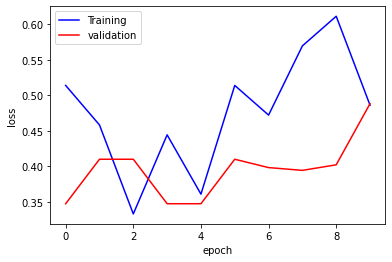

In [ ]:
plt.plot(accuracy,'-b')
plt.plot(val_acc,'-r')
plt.legend(["Training","validation"])
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])
dataset = ImageFolder(data_dir+'/validation', transform=data_transform)

In [ ]:
test_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
#         print(labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


Accuracy of the network: 58.74125874125874 %


Improved Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2 ,2), 
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.25),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(), 
            nn.Linear(512*6*6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 7))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, data):
        images, labels = data 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)
        # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    

In [ ]:
model2 = CNN().to(device)

In [ ]:
model2

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Linear(in_features=18432, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
history_new = fit(model2,10,criterion,optimizer)

100%|██████████| 41/41 [04:14<00:00,  6.20s/it]

Epoch [1/10], Loss: 1.2923,Accuracy: 0.3472



100%|██████████| 41/41 [04:11<00:00,  6.12s/it]

Epoch [2/10], Loss: 1.0947,Accuracy: 0.4028



100%|██████████| 41/41 [04:12<00:00,  6.15s/it]

Epoch [3/10], Loss: 1.1540,Accuracy: 0.4722



100%|██████████| 41/41 [04:12<00:00,  6.15s/it]

Epoch [4/10], Loss: 1.2553,Accuracy: 0.4167



100%|██████████| 41/41 [04:12<00:00,  6.17s/it]

Epoch [5/10], Loss: 1.1793,Accuracy: 0.3056



100%|██████████| 41/41 [04:11<00:00,  6.14s/it]

Epoch [6/10], Loss: 1.2684,Accuracy: 0.2500



100%|██████████| 41/41 [04:13<00:00,  6.18s/it]

Epoch [7/10], Loss: 1.2355,Accuracy: 0.4028



100%|██████████| 41/41 [04:11<00:00,  6.13s/it]

Epoch [8/10], Loss: 1.2105,Accuracy: 0.5139



100%|██████████| 41/41 [04:12<00:00,  6.16s/it]

Epoch [9/10], Loss: 1.2182,Accuracy: 0.4028



100%|██████████| 41/41 [04:10<00:00,  6.11s/it]

Epoch [10/10], Loss: 1.1388,Accuracy: 0.4444


In [ ]:
accuracy = history_new["acc"]
loss= history_new["loss"]
val_loss=[]
for i in history_new["val_loss"]:
  val_loss.append(i.cpu().numpy())
val_acc = history_new["val_acc"]

Text(0, 0.5, 'loss')

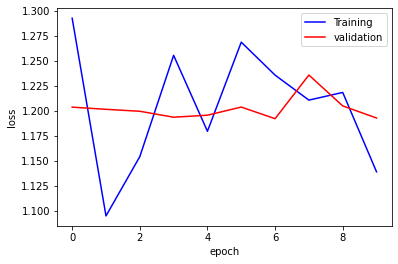

In [ ]:
plt.plot(loss,'-b')
plt.plot(val_loss,'-r')
plt.legend(["Training","validation"])
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

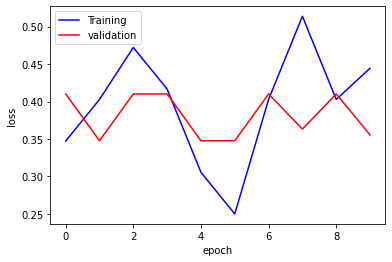

In [ ]:
plt.plot(accuracy,'-b')
plt.plot(val_acc,'-r')
plt.legend(["Training","validation"])
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
#         print(labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


Accuracy of the network: 74.12587412587412 %
